Goal: train a U-net to overtrain on a single image of me (or something else), and be able to produce it from Gaussian noise. Then run some tests and see what it generates on random sample pictures

In [1]:
from models import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import os
from torchvision.transforms import v2 
import torchvision.transforms
from torchvision.io import decode_image

from tqdm import tqdm

# -----

device = "cpu" 
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps:0"

dtype = torch.float32
if device != 'cpu':
    dtype = torch.bfloat16



In [2]:
#Initialize model 

model = UNet()

#model.load_state_dict(torch.load("models_weights/ckpt.pt", weights_only=True))
model.eval()
model.to(device)

#model = torch.compile(model)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(1, 8, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): GroupNorm(1, 8, eps=1e-05, affine=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): GroupNorm(1, 8, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
          (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): GroupNorm(1, 8, eps=1e-05, affine=True)
        )
        (dropout): Dropout(p=0.0, inplac

In [3]:
import logging
from torch.utils.tensorboard import SummaryWriter

image = "alex.jpeg"

alex = decode_image(image)
alex = v2.Resize((64,64))(alex)

data = encode(alex)


epochs = 40
batch_size = 16
image_size = 64


def train(model, learn_rate, run_name):
    setup_logging(run_name = run_name)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learn_rate)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=image_size, device=device)
    logger = SummaryWriter(os.path.join("runs"))

    for epoch in range(epochs):
        logging.info(f"Starting epoch {epoch}:")
        #16 images per batch
        images = data.unsqueeze(0).repeat(batch_size,1,1,1).to(device)
        loss_accum = 0
        for i in tqdm(range(1000)):
            with torch.autocast(device_type=device, dtype=dtype):
                t = diffusion.sample_timesteps(images.shape[0]).to(device)
                x_t, noise = diffusion.noise_images(images, t)
                predicted_noise = model(x_t, t)
                loss = mse(noise, predicted_noise)
                
            optimizer.zero_grad()
            loss_accum += loss.detach()            
            loss.backward()
            optimizer.step()
            logger.add_scalar("MSE", loss.item(), global_step=epoch * 1000 + i)

        print(f"Finished training epoch {epoch}")
        print(f"Average Loss: {loss_accum/1000}")

        if epoch % 5 == 0 or epoch == epochs-1:
            with torch.autocast(device_type = device, dtype = torch.bfloat16):
                sampled_images = diffusion.sample(model, n=4)
            sampled_images = sampled_images.detach().cpu()
            show([sampled_images[i] for i in range(len(sampled_images))])
            save_images(sampled_images, os.path.join(f"results/{run_name}/", f"{epoch}"))
        torch.save(model.state_dict(), os.path.join("models_weights", f"ckpt.pt"))



100%|██████████| 1000/1000 [10:42<00:00,  1.56it/s]


Finished training epoch 0
Average Loss: 0.04856003075838089


999it [02:08,  7.80it/s]
100%|██████████| 1000/1000 [10:40<00:00,  1.56it/s]


Finished training epoch 1
Average Loss: 0.046752266585826874


100%|██████████| 1000/1000 [10:35<00:00,  1.57it/s]


Finished training epoch 2
Average Loss: 0.04410499334335327


100%|██████████| 1000/1000 [10:39<00:00,  1.56it/s]


Finished training epoch 3
Average Loss: 0.04294350743293762


100%|██████████| 1000/1000 [10:44<00:00,  1.55it/s]


Finished training epoch 4
Average Loss: 0.04207676649093628


100%|██████████| 1000/1000 [10:44<00:00,  1.55it/s]


Finished training epoch 5
Average Loss: 0.03993441164493561


999it [02:01,  8.22it/s]
100%|██████████| 1000/1000 [10:43<00:00,  1.55it/s]


Finished training epoch 6
Average Loss: 0.04015488922595978


100%|██████████| 1000/1000 [10:25<00:00,  1.60it/s]


Finished training epoch 7
Average Loss: 0.038218170404434204


100%|██████████| 1000/1000 [10:29<00:00,  1.59it/s]


Finished training epoch 8
Average Loss: 0.036861762404441833


100%|██████████| 1000/1000 [10:34<00:00,  1.58it/s]


Finished training epoch 9
Average Loss: 0.036415260285139084


100%|██████████| 1000/1000 [10:31<00:00,  1.58it/s]


Finished training epoch 10
Average Loss: 0.035039231181144714


999it [02:01,  8.23it/s]
100%|██████████| 1000/1000 [10:52<00:00,  1.53it/s]


Finished training epoch 11
Average Loss: 0.035466622561216354


100%|██████████| 1000/1000 [10:42<00:00,  1.56it/s]


Finished training epoch 12
Average Loss: 0.03443514183163643


100%|██████████| 1000/1000 [10:44<00:00,  1.55it/s]


Finished training epoch 13
Average Loss: 0.032815102487802505


100%|██████████| 1000/1000 [10:38<00:00,  1.57it/s]


Finished training epoch 14
Average Loss: 0.03311452269554138


100%|██████████| 1000/1000 [10:36<00:00,  1.57it/s]


Finished training epoch 15
Average Loss: 0.03151540458202362


999it [02:04,  8.01it/s]
100%|██████████| 1000/1000 [10:35<00:00,  1.57it/s]


Finished training epoch 16
Average Loss: 0.03098289668560028


100%|██████████| 1000/1000 [10:33<00:00,  1.58it/s]


Finished training epoch 17
Average Loss: 0.030946964398026466


100%|██████████| 1000/1000 [10:35<00:00,  1.57it/s]


Finished training epoch 18
Average Loss: 0.029557526111602783


100%|██████████| 1000/1000 [10:32<00:00,  1.58it/s]


Finished training epoch 19
Average Loss: 0.02979767508804798


100%|██████████| 1000/1000 [10:40<00:00,  1.56it/s]


Finished training epoch 20
Average Loss: 0.028265871107578278


999it [02:02,  8.18it/s]
100%|██████████| 1000/1000 [10:41<00:00,  1.56it/s]


Finished training epoch 21
Average Loss: 0.028868531808257103


100%|██████████| 1000/1000 [10:44<00:00,  1.55it/s]


Finished training epoch 22
Average Loss: 0.02875189669430256


100%|██████████| 1000/1000 [10:39<00:00,  1.56it/s]


Finished training epoch 23
Average Loss: 0.028410164639353752


100%|██████████| 1000/1000 [10:25<00:00,  1.60it/s]


Finished training epoch 24
Average Loss: 0.02718586102128029


100%|██████████| 1000/1000 [10:25<00:00,  1.60it/s]


Finished training epoch 25
Average Loss: 0.026218954473733902


999it [01:59,  8.38it/s]
100%|██████████| 1000/1000 [10:25<00:00,  1.60it/s]


Finished training epoch 26
Average Loss: 0.02651106007397175


100%|██████████| 1000/1000 [10:25<00:00,  1.60it/s]


Finished training epoch 27
Average Loss: 0.025135744363069534


100%|██████████| 1000/1000 [10:25<00:00,  1.60it/s]


Finished training epoch 28
Average Loss: 0.026301035657525063


100%|██████████| 1000/1000 [10:23<00:00,  1.60it/s]


Finished training epoch 29
Average Loss: 0.025420593097805977


100%|██████████| 1000/1000 [10:22<00:00,  1.61it/s]


Finished training epoch 30
Average Loss: 0.02605321817100048


999it [02:07,  7.83it/s]
100%|██████████| 1000/1000 [10:26<00:00,  1.60it/s]


Finished training epoch 31
Average Loss: 0.02469419687986374


100%|██████████| 1000/1000 [10:26<00:00,  1.60it/s]


Finished training epoch 32
Average Loss: 0.025488290935754776


100%|██████████| 1000/1000 [10:26<00:00,  1.60it/s]


Finished training epoch 33
Average Loss: 0.024125074967741966


100%|██████████| 1000/1000 [10:25<00:00,  1.60it/s]


Finished training epoch 34
Average Loss: 0.023646045476198196


100%|██████████| 1000/1000 [10:25<00:00,  1.60it/s]


Finished training epoch 35
Average Loss: 0.02271554246544838


999it [02:02,  8.15it/s]
100%|██████████| 1000/1000 [10:29<00:00,  1.59it/s]


Finished training epoch 36
Average Loss: 0.022976364940404892


100%|██████████| 1000/1000 [10:25<00:00,  1.60it/s]


Finished training epoch 37
Average Loss: 0.022442197427153587


100%|██████████| 1000/1000 [10:25<00:00,  1.60it/s]


Finished training epoch 38
Average Loss: 0.022584743797779083


100%|██████████| 1000/1000 [10:23<00:00,  1.60it/s]


Finished training epoch 39
Average Loss: 0.021866418421268463


999it [02:06,  7.90it/s]


'\ndata2 = data.unsqueeze(0).repeat(16,1,1,1)\nprint(data2.size())\n'

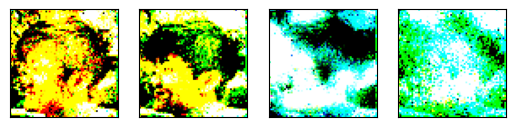

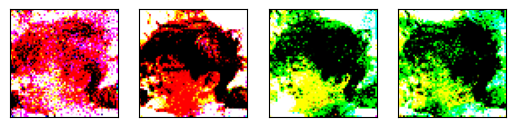

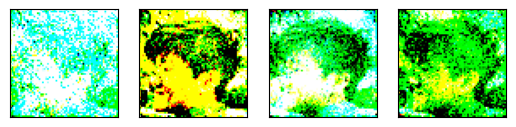

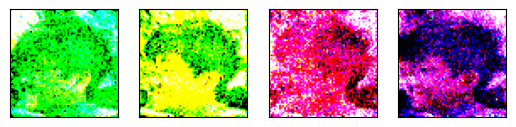

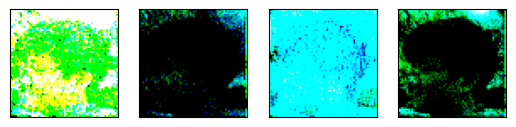

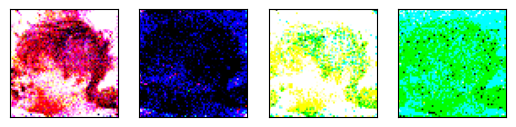

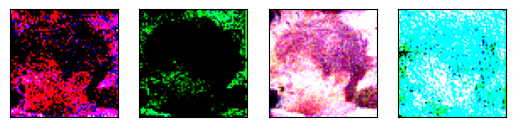

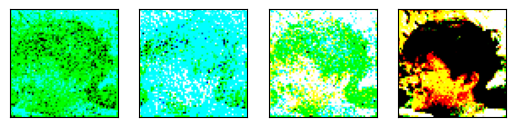

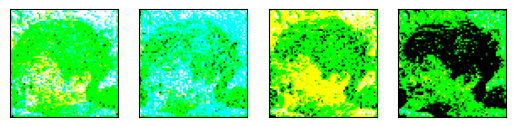

In [6]:
# training run
learn_rate = 2e-5
run_name = "learn_alex3pt2"

train(model, learn_rate, run_name)


"""
data2 = data.unsqueeze(0).repeat(16,1,1,1)
print(data2.size())
"""

In [5]:
# Parameter counter
count = 0
for p in model.parameters():
    count += p.numel()
print(count)
# 874523 params

874523


In [ ]:
# Check image generation + saving works
diffusion = Diffusion(device = device)
with torch.autocast(device_type = device, dtype = torch.bfloat16):
    sampled_images = diffusion.sample(model, n=8)
sampled_images = sampled_images.cpu()
show([sampled_images[i] for i in range(len(sampled_images))])
save_images(sampled_images, os.path.join("test"))

{0: 0.042725980281829834, 1: 0.022821469232439995, 2: 0.013716327026486397, 3: 0.010446569882333279, 4: 0.009611128829419613, 5: 0.009186837822198868, 6: 0.009112956002354622, 7: 0.0096647460013628, 8: 0.010548517107963562}
Noise:
timestep: 50, loss: 0.042725980281829834
timestep: 100, loss: 0.022821469232439995
timestep: 200, loss: 0.013716327026486397
timestep: 300, loss: 0.010446569882333279
timestep: 400, loss: 0.009611128829419613
timestep: 500, loss: 0.009186837822198868
timestep: 600, loss: 0.009112956002354622
timestep: 700, loss: 0.0096647460013628
timestep: 999, loss: 0.010548517107963562


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(1, 8, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): GroupNorm(1, 8, eps=1e-05, affine=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): GroupNorm(1, 8, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
          (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): GroupNorm(1, 8, eps=1e-05, affine=True)
        )
        (dropout): Dropout(p=0.0, inplac

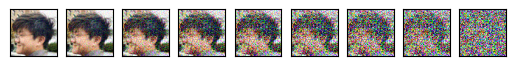

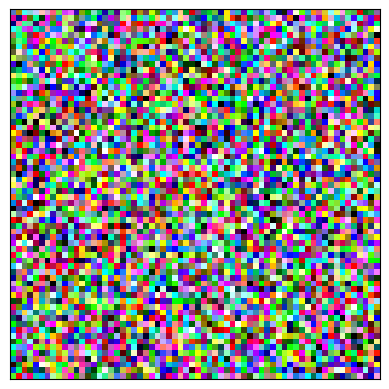

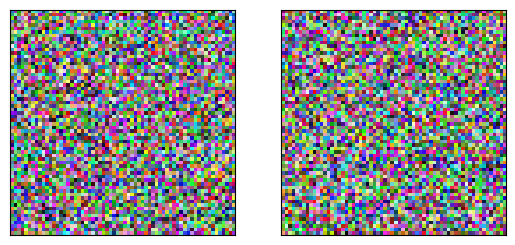

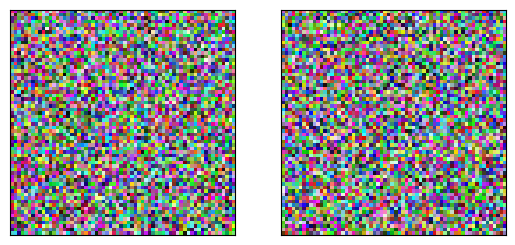

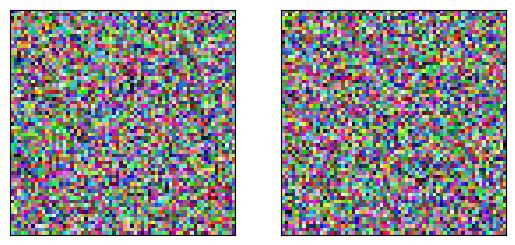

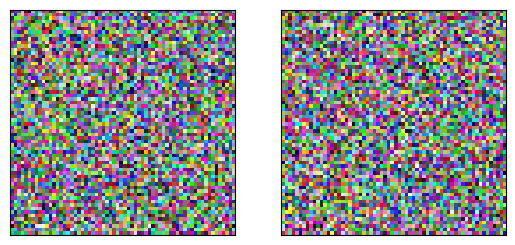

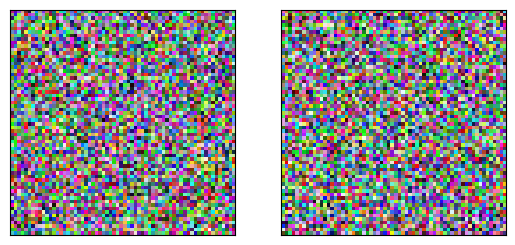

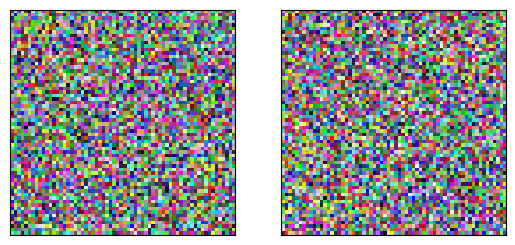

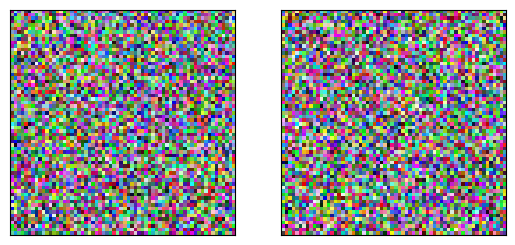

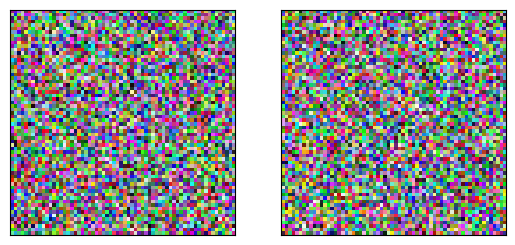

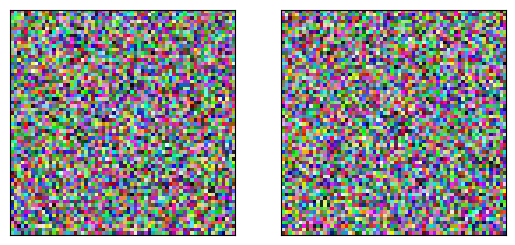

In [7]:
#Check that noising works properly
#Evaluate what the model is learning

diff = Diffusion(device=device)

t = torch.Tensor([50, 100, 200, 300, 400, 500, 600, 700, 999]).long().to(device)
mps_alex = encode(alex).to(device)

noised_image, noise = diff.noise_images(mps_alex, t)
predicted_noise = model(noised_image, t)


mse = nn.MSELoss()
model.eval()
losses = {}

with torch.no_grad():
    for i in range(len(t)):
        loss = mse(noise, predicted_noise[i])
        losses[i] = loss.clone().item()
print(losses)

noised_image.detach()
predicted_noise.detach()
noise.detach()


noised_image = decode(noised_image)
show([noised_image[i] for i in range(len(noised_image))])


noise = decode(noise)
print("Noise:")
show(noise)

for i in range(len(t)):
    print(f"timestep: {t[i]}, loss: {losses[i]}")
    err = abs(noise - predicted_noise[i])
    show([predicted_noise[i], err])



model.train()


In [ ]:
half_pi = torch.acos(torch.zeros(1)).item() #approx pi/2
s = torch.sqrt(torch.tensor(1e-4)) / half_pi

alpha_hat1 = torch.cos(torch.linspace(s, half_pi - s, 1000)) ** 2
print(alpha_hat1[-1])

alpha_shift = torch.roll(alpha_hat1, 1, 0)
alpha_shift[0] = 1
alpha = alpha_hat1 / alpha_shift
beta = 1 - alpha


beta2 = torch.linspace(1e-4, 0.01, 1000)
alpha2 = 1. - beta2
alpha_hat2 = torch.cumprod(alpha2, dim=0)

In [ ]:
#plot various noising schedueles 

plt.plot(range(1000), alpha_hat1)
plt.plot(range(1000), alpha_hat2)
indices = [50, 100, 150, 200, 300, 600, 700, 999]
print([alpha_hat1[i] for i in indices])
print([alpha_hat2[i] for i in indices])

In [ ]:
import torch
import torch.nn as nn

B, size, C = 3, 8, 7
t_emb = nn.Embedding(1000 + 1, C)
p_emb = nn.Embedding(size * size, C)

t = torch.tensor([0,50,100]) #4 batches
pos = torch.arange(0,size*size, dtype=torch.long, device = 'cpu')

time_emb = t_emb(t).unsqueeze(1)
time_emb = time_emb.repeat(1,size*size,1)
pos_emb = p_emb(pos)

print(t.shape, pos.shape)
print(time_emb.shape, pos_emb.shape)

emb = time_emb + pos_emb
print(emb.shape)

In [10]:
list = [0,1,2,3,4,5,6,7,8,9]
print(list)
print(list[3:7])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[3, 4, 5, 6]
